In [1]:
from landlab import RasterModelGrid
from landlab.components import FlowAccumulator, GravelBedrockEroder
from landlab import RasterModelGrid, imshow_grid
import numpy as np 


In [2]:
import copy

import matplotlib as mpl
import matplotlib.pyplot as plt  # For plotting results; optional
import numpy as np

from landlab import RasterModelGrid  # Grid utility
from landlab import imshow_grid, imshowhs_grid  # For plotting results; optional
from landlab.components import BedrockLandslider  # BedrockLandslider model
from landlab.components import SpaceLargeScaleEroder  # SPACE model
from landlab.components import PriorityFloodFlowRouter

In [3]:
# Set grid parameters
num_rows = 30
num_columns = 30
node_spacing = 25.0

# track sediment flux at the node adjacent to the outlet at lower-left
node_next_to_outlet = num_columns + 1

# Instantiate model grid
mg = RasterModelGrid((num_rows, num_columns), node_spacing)
# add field ’topographic elevation’ to the grid
mg.add_zeros("node", "topographic__elevation")
# set constant random seed for consistent topographic roughness
np.random.seed(seed=10000)

# Create initial model topography:

# add topographic roughness
random_noise = (
    np.random.rand(len(mg.node_y)) / 1000.0
)  # impose topography values on model grid
mg["node"]["topographic__elevation"] += random_noise

# add field 'soil__depth' to the grid
mg.add_zeros("node", "soil__depth")

# Set 2 m of initial soil depth at core nodes
mg.at_node["soil__depth"][mg.core_nodes] = 1.0  # meters

# Add field 'bedrock__elevation' to the grid
mg.add_zeros("bedrock__elevation", at="node")

# Sum 'soil__depth' and 'bedrock__elevation'
# to yield 'topographic elevation'
mg.at_node["bedrock__elevation"][:] = mg.at_node["topographic__elevation"]
mg.at_node["topographic__elevation"][:] += mg.at_node["soil__depth"]

In [4]:
## Set boundry conditions

# Open all model boundary edges
mg.set_closed_boundaries_at_grid_edges(
    bottom_is_closed=True,
    left_is_closed=True,
    right_is_closed=True,
    top_is_closed=True,
)
mg.status_at_node[5] = 1 

In [5]:
### Initialize different components
# Instantiate flow router
fr = PriorityFloodFlowRouter(mg, flow_metric="D8", suppress_out=True)

# Instantiate SPACE model with chosen parameters
sp = SpaceLargeScaleEroder(
    mg,
    K_sed=2.5e-5,
    K_br=2.5e-5,
    F_f=0.0,
    phi=0.0,
    H_star=1.0,
    v_s=1,
    m_sp=0.5,
    n_sp=1.0,
    sp_crit_sed=0,
    sp_crit_br=0,
)

0.20 of model run completed


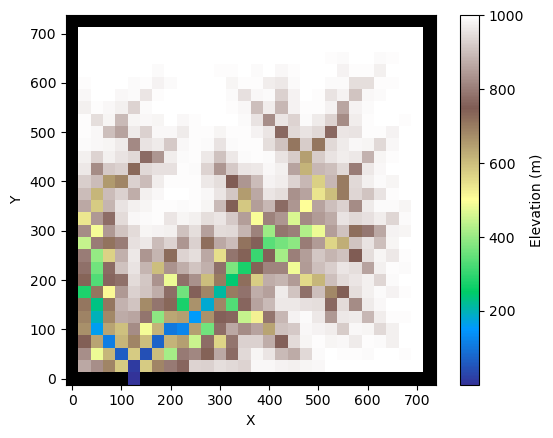

0.40 of model run completed


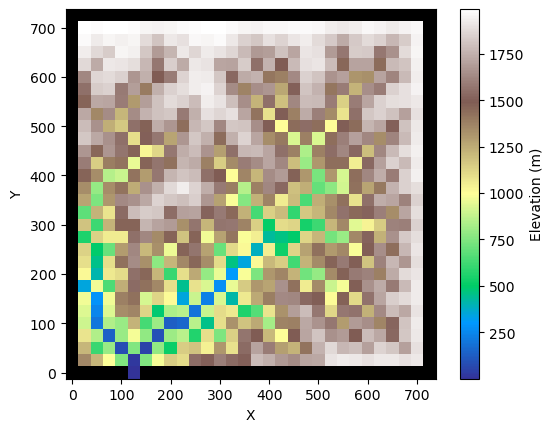

0.60 of model run completed


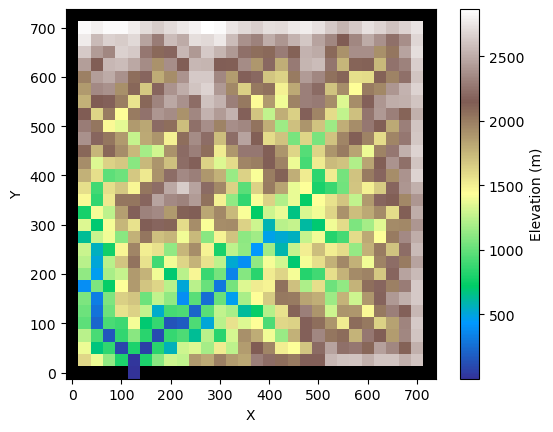

0.80 of model run completed


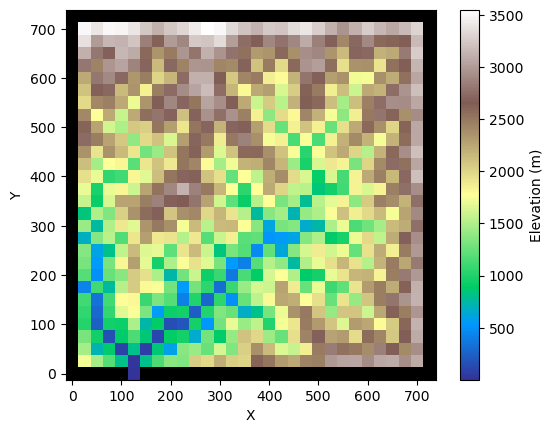

1.00 of model run completed


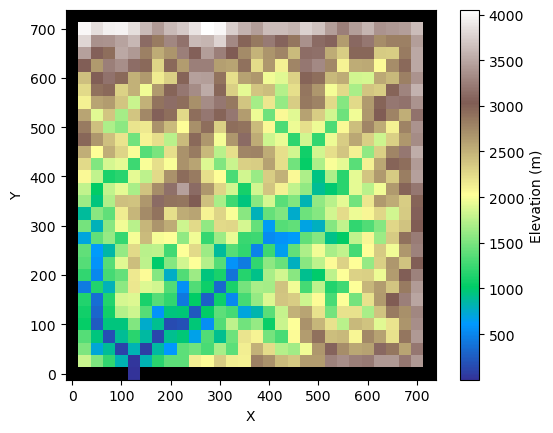

In [6]:
## Run SPACE to generate fake landscape

# Set model timestep
timestep = 5e2  # years

# Set elapsed time to zero
elapsed_time = 0.0  # years

# Set timestep count to zero
count = 0

# Set model run time
run_time = 5e5  # years

# Array to save sediment flux values
sed_flux = np.zeros(int(run_time // timestep))

# Uplift rate in m/yr
U = 1e-2

cmap = copy.copy(mpl.colormaps["terrain"])

while elapsed_time < run_time:  # time units of years
    # Insert uplift at core nodes
    mg.at_node["bedrock__elevation"][mg.core_nodes] += U * timestep
    mg.at_node["topographic__elevation"][:] = (
        mg.at_node["bedrock__elevation"] + mg.at_node["soil__depth"]
    )

    # Run the flow router
    fr.run_one_step()

    # Run SPACE for one time step
    sp.run_one_step(dt=timestep)

    # Add to value of elapsed time
    elapsed_time += timestep

    if np.mod(elapsed_time, 1e5) == 0:
        print("%.2f of model run completed" % (elapsed_time / run_time))
        imshow_grid(
            mg, "topographic__elevation", cmap=cmap, colorbar_label="Elevation (m)"
        )
        plt.show()

In [7]:
### Check the fields name
#mg.fields()

In [9]:
############### Now the eroder part #########################

In [18]:
## Evolve that landscape 
fa = FlowAccumulator(mg, runoff_rate=10.0)
fa.run_one_step()
eroder = GravelBedrockEroder(mg, abrasion_coefficient=0.0005,
                            coarse_fraction_from_plucking=0.1)
rock_elev = mg.at_node["bedrock__elevation"]
elev = mg.at_node["topographic__elevation"]
#years_forward = mg.add_zeros["years_in_future", at = "node"]
for i in range(200):
     rock_elev[mg.core_nodes] += 1e-2
     elev[mg.core_nodes] += 1e-2
     fa.run_one_step()
     mg.at_node["surface_water__discharge"]
     chan_width = eroder.calc_implied_width(time_unit="s")
     eroder.calc_sediment_rate_of_change(),
     eroder.run_one_step(1.0)
#int(elev[4] * 100)

FlowAccumulator found both the field 'water__unit_flux_in' and a provided float or array for the runoff_rate argument. THE FIELD IS BEING OVERWRITTEN WITH THE SUPPLIED RUNOFF_RATE!


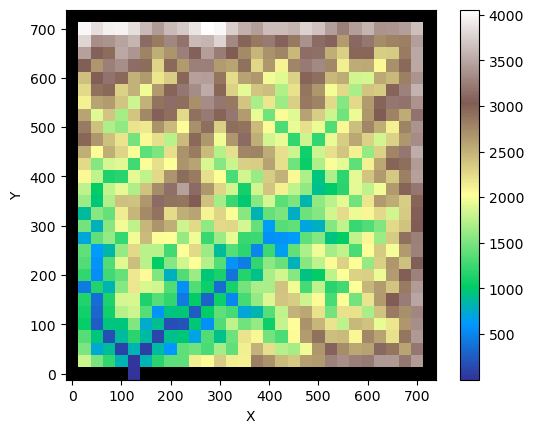

In [19]:
imshow_grid(mg, elev, cmap = "terrain")

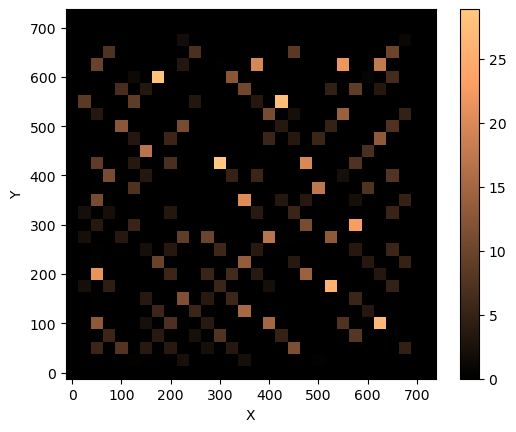

In [20]:
imshow_grid(mg, "soil__depth", cmap = "copper")

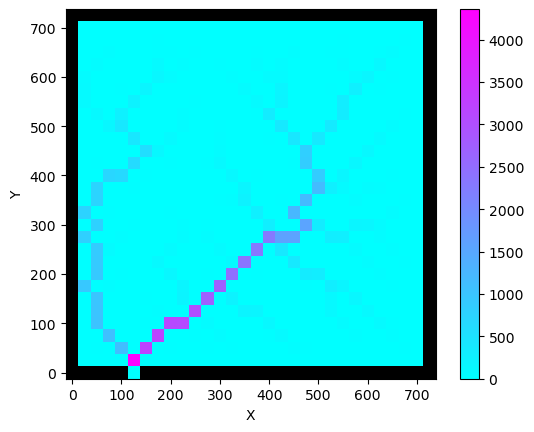

In [21]:
imshow_grid(mg, "sediment__flux", cmap = "cool")

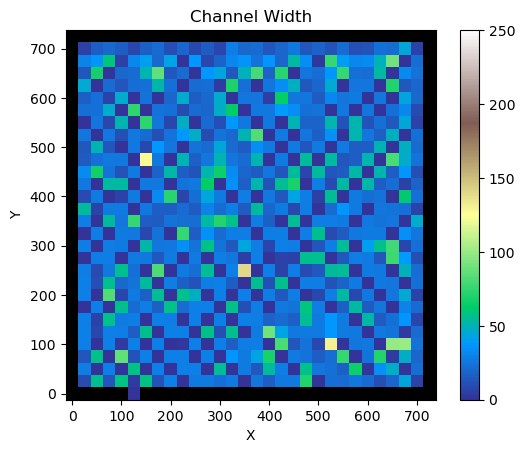

In [17]:
imshow_grid(mg, chan_width,
            vmax = 250,
            plot_name = "Channel Width", 
            cmap = "terrain")

In [ ]:
#np.nanpercentile(chan_width, 99)

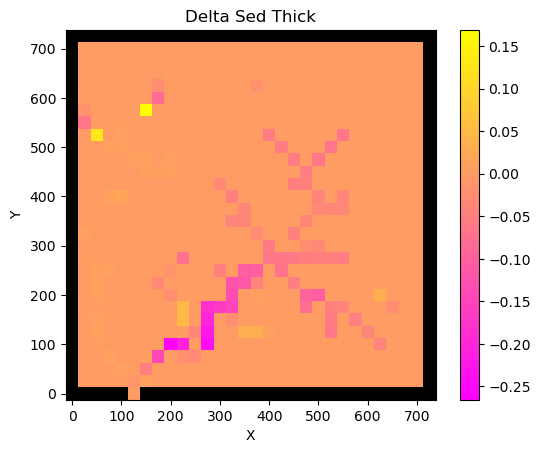

In [ ]:
imshow_grid(mg, "sediment__rate_of_change",
            #vmax = 250,
            plot_name = "Delta Sed Thick", 
            cmap = "spring")